# Predicting incorrect student answers from DataShop data
<p style="margin:30px">
    <img width=50% src="https://www.featuretools.com/wp-content/uploads/2017/12/FeatureLabs-Logo-Tangerine-800.png" alt="Featuretools" />
</p>

In this tutorial, we show how to predict whether a student will succesfully answer a problem using a dataset from [CMU DataShop](https://pslcdatashop.web.cmu.edu/). While online courses are logistically efficient, the structure can make it more difficult for a teacher to understand how students are learning in their class. To try to fill in those gaps, we can apply machine learning. However, building an accurate machine learning model requires extracting information called **features**. Finding the right features is a crucial component of both finding a satisfactory answer and of interpreting the dataset as a whole. The process of **feature engineering** is made simple by [Featuretools](http://www.featuretools.com).

*If you're running this notebook yourself, please download the [geometry dataset](https://pslcdatashop.web.cmu.edu/DatasetInfo?datasetId=76) into the `data` folder in this repository. You can follow these [instructions](https://pslcdatashop.web.cmu.edu/help?datasetId=76&page=export) to download the data. You will only need the `.txt` file. The infrastructure in this notebook will work with **any** DataShop dataset, but you will need to change the file name in the first cell.*

## Highlights
* Show how to import a DataShop dataset into featuretools
* Demonstrate efficacy of automatic feature generation by training a machine learning model 
* Give an example of how Featuretools can reveal and help answer interesting questions

# Step 1: Load data
At the beginning of any project, it is worthwhile to take a moment to think about how your dataset is structured.

In these datasets the unique events come from `transactions`: places where a student interacts with a system. Each transaction has a `time-index`, the time at which information in a row becomes known. Furthermore, the columns of those transactions have variables that can be grouped together. 

For instance, there are only 59 distinct students for the 6778 transactions we have in the geometry dataset. Those students log in to the system and have individual sessions. We can break down problems and problem steps in a similar way.

Featuretools stores data in an `EntitySet`. This is an abstraction which allows us to hold on to not only the data itself, but also to metadata like relationships and column types.

We create an entityset structure using the `datashop_to_entityset` function in [utils](utils.py). If you're interested in how `datashop_to_entityset` is structured, there's an associated notebook [entityset_function](entityset_function.ipynb) which explains choices made in more detail.

In [1]:
# Note that each branch is a one -> many relationship

# schools       students     problems
#        \        |         /
#   classes   sessions   problem steps
#          \     |       /
#           transactions
#

import utils

filename = 'data/ds76_tx_All_Data_74_2018_0912_070949.txt'
es = utils.datashop_to_entityset(filename)
es

Entityset: Dataset
  Entities:
    transactions [Rows: 6778, Columns: 26]
    problem_steps [Rows: 78, Columns: 156]
    problems [Rows: 20, Columns: 2]
    sessions [Rows: 59, Columns: 3]
    students [Rows: 59, Columns: 2]
    classes [Rows: 1, Columns: 2]
    schools [Rows: 1, Columns: 1]
  Relationships:
    transactions.Step Name -> problem_steps.Step Name
    problem_steps.Problem Name -> problems.Problem Name
    transactions.Session Id -> sessions.Session Id
    sessions.Anon Student Id -> students.Anon Student Id
    transactions.Class -> classes.Class
    classes.School -> schools.School

Our `students` entity represents that: there are only 59 rows, one for each Anonymous student ID.

In [2]:
es['students'].df.head(3)

,Anon Student Id,first_sessions_time
Stu_c0bf45c22dc46067350d304ce330067e,Stu_c0bf45c22dc46067350d304ce330067e,1996-02-01 00:00:00
Stu_af3a2f63bda8c1338556108cb8d519a0,Stu_af3a2f63bda8c1338556108cb8d519a0,1996-02-01 00:00:02
Stu_e242582bd5729de82485e42d69e22109,Stu_e242582bd5729de82485e42d69e22109,1996-02-01 00:00:02


Featuretools allows us to make new entities as grouped by categorical values. Through this process of *normalization* we have created 8 connected entities from an initial table of transactions. We can look at what is left in `transactions` after normalization.

In [3]:
es['transactions'].df.head(3)

,Transaction Id,Sample Name,Session Id,Time,Time Zone,Duration (sec),Student Response Type,Student Response Subtype,Tutor Response Type,Tutor Response Subtype,...,Action,Input,Feedback Text,Feedback Classification,Help Level,Total Num Hints,Class,End Time,Outcome,Attempt At Step
bdc63de3ac6ace889eed3850997ea333,bdc63de3ac6ace889eed3850997ea333,All Data,GEO-408d5ed7:10e14be5d3a:-8000,1996-02-01 00:00:00,US/Eastern,0,ATTEMPT,NaN,RESULT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996-02-01 00:00:00,0,1
34f5d8fcf207513d222bf6d1bced2046,34f5d8fcf207513d222bf6d1bced2046,All Data,GEO-408d5ed7:10e14be5d3a:-8000,1996-02-01 00:00:01,US/Eastern,1,ATTEMPT,NaN,RESULT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996-02-01 00:00:02,1,2
171f36289815d9782f8beab6ad8b0fac,171f36289815d9782f8beab6ad8b0fac,All Data,GEO-408d5ed7:10e14be5d3a:-791a,1996-02-01 00:00:02,US/Eastern,0,ATTEMPT,NaN,RESULT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996-02-01 00:00:02,0,1


In [4]:
es['transactions'].last_time_index

## Visualize EntitySet

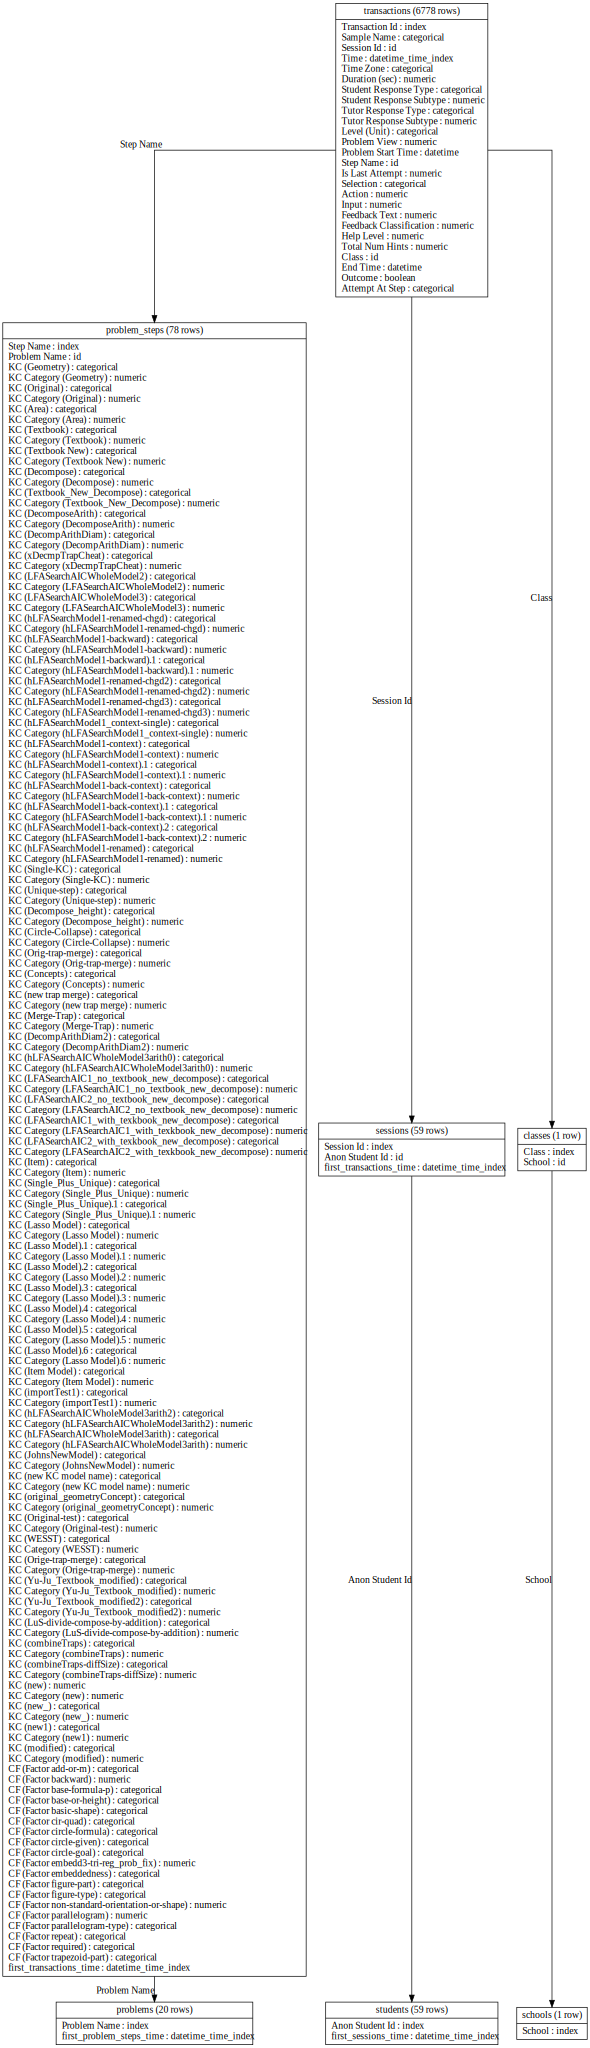

In [5]:
es.plot()

# Step 2: Building Features
Next, we calculate a feature matrix on the `transactions` entity to try to predict the outcome of a given transaction. It's at this step that our previous setup pays off: we can automatically calculate features using data from the whole `EntitySet`. 

## Cutoff times
We are going to be generating features and doing predictive modeling on time-sensitive data. That comes with a high risk of label leakage. 

In this case, we are predicting if a student will get a particular problem correct. For a fixed problem, the feature "There exists an attempt number three" would be highly predictive of the result on attempts one and two. There can only be a third attempt if there first two attempts were wrong! In that way, storing future `attempt` information in a feature to predict `Outcome` would yield higher test accuracy than the model deserves. It's not ok to have the feature "There exists an attempt number three" while predicting attempts one and two because it contains information that can not be known at that point in time.

To circumvent that, we introduce the notion of [cutoff_times](https://docs.featuretools.com/en/stable/automated_feature_engineering/handling_time.html#). A `cutoff_time` has an index column and a datetime column indicating the last acceptable date we can use while generating features for a historical training example. We can also add in a label, which will be passed through Deep Feature Synthesis ([DFS](https://docs.featuretools.com/en/stable/automated_feature_engineering/afe.html)) untouched so we can recover it later.

Setting cutoff times immediately mitigates the risk of fraudulently using future data, controls the number of predictions we make and controls what data is used while calculating features.


In [6]:
cutoff_times = es['transactions'].df[['Transaction Id', 'End Time', 'Outcome']]
# Cutoff time values should be named either `time` or the same as the target entity time index
cutoff_times = cutoff_times.rename(columns={'End Time': 'time'})
cutoff_times.head()

,Transaction Id,time,Outcome
bdc63de3ac6ace889eed3850997ea333,bdc63de3ac6ace889eed3850997ea333,1996-02-01 00:00:00,0
34f5d8fcf207513d222bf6d1bced2046,34f5d8fcf207513d222bf6d1bced2046,1996-02-01 00:00:02,1
171f36289815d9782f8beab6ad8b0fac,171f36289815d9782f8beab6ad8b0fac,1996-02-01 00:00:02,0
5ad4ed1a55851edb89fc23d8ed4076e1,5ad4ed1a55851edb89fc23d8ed4076e1,1996-02-01 00:00:02,1
de0bfeea6b32cb37891c0b7dbc6b7a18,de0bfeea6b32cb37891c0b7dbc6b7a18,1996-02-01 00:00:02,1


With that in hand, we can guarentee that future values for `Outcome` won't be used for any calculations because we set the time index of `Outcome` to be after the cutoff time.

From there, we can call `ft.dfs` to generate our features and feature matrix. Deep Feature Synthesis creates features using reusable functions ([Primitives](https://docs.featuretools.com/en/stable/automated_feature_engineering/primitives.html)). The algorithm attempts to combine primitives together with actual data to create a feature matrix. Here, we'll use the primitives `Sum`, `Mean`, `PercentTrue` and `Hour`. On an ordinary laptop, you should expect the following cell to take roughly 40 minutes to complete as there are more than 3000 unique cutoff times. For faster results, uncomment the approximate line. 

In [7]:
import featuretools as ft
from featuretools.selection import remove_low_information_features

import pandas as pd
import numpy as np
pd.options.display.max_columns = 500

fm, features = ft.dfs(entityset=es,
                      target_entity='transactions',
                      agg_primitives=['Sum', 'Mean', 'Percent_True'],
                      trans_primitives=['Hour'],
                      max_depth=3,
                      # approximate='2m',
                      cutoff_time=cutoff_times[1000:],
                      verbose=True)

# Encode the feature matrix using One-Hot encoding
fm_enc, f_enc = ft.encode_features(fm, features)
fm_enc = fm_enc.fillna(0)
fm_enc = remove_low_information_features(fm_enc)

# Pop the label
label = fm_enc.pop('Outcome')

fm.tail()

Built 467 features
Elapsed: 00:00 | Progress:   0%|          

/Users/theinl/miniconda3/envs/environmentForDemos/lib/python3.8/site-packages/featuretools/synthesis/dfs.py:317: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
  trans_primitives: ['Hour']
  agg_primitives: ['Mean', 'Percent_True', 'Sum']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
  warnings.warn(warning_msg, UnusedPrimitiveWarning)


Elapsed: 16:57 | Progress: 100%|██████████


,Sample Name,Session Id,Time Zone,Duration (sec),Student Response Type,Student Response Subtype,Tutor Response Type,Tutor Response Subtype,Level (Unit),Problem View,Step Name,Is Last Attempt,Selection,Action,Input,Feedback Text,Feedback Classification,Help Level,Total Num Hints,Class,Outcome,Attempt At Step,HOUR(End Time),HOUR(Problem Start Time),HOUR(Time),problem_steps.Problem Name,problem_steps.KC (Geometry),problem_steps.KC Category (Geometry),problem_steps.KC (Original),problem_steps.KC Category (Original),problem_steps.KC (Area),problem_steps.KC Category (Area),problem_steps.KC (Textbook),problem_steps.KC Category (Textbook),problem_steps.KC (Textbook New),problem_steps.KC Category (Textbook New),problem_steps.KC (Decompose),problem_steps.KC Category (Decompose),problem_steps.KC (Textbook_New_Decompose),problem_steps.KC Category (Textbook_New_Decompose),problem_steps.KC (DecomposeArith),problem_steps.KC Category (DecomposeArith),problem_steps.KC (DecompArithDiam),problem_steps.KC Category (DecompArithDiam),problem_steps.KC (xDecmpTrapCheat),problem_steps.KC Category (xDecmpTrapCheat),problem_steps.KC (LFASearchAICWholeModel2),problem_steps.KC Category (LFASearchAICWholeModel2),problem_steps.KC (LFASearchAICWholeModel3),problem_steps.KC Category (LFASearchAICWholeModel3),problem_steps.KC (hLFASearchModel1-renamed-chgd),problem_steps.KC Category (hLFASearchModel1-renamed-chgd),problem_steps.KC (hLFASearchModel1-backward),problem_steps.KC Category (hLFASearchModel1-backward),problem_steps.KC (hLFASearchModel1-backward).1,problem_steps.KC Category (hLFASearchModel1-backward).1,problem_steps.KC (hLFASearchModel1-renamed-chgd2),problem_steps.KC Category (hLFASearchModel1-renamed-chgd2),problem_steps.KC (hLFASearchModel1-renamed-chgd3),problem_steps.KC Category (hLFASearchModel1-renamed-chgd3),problem_steps.KC (hLFASearchModel1_context-single),problem_steps.KC Category (hLFASearchModel1_context-single),problem_steps.KC (hLFASearchModel1-context),problem_steps.KC Category (hLFASearchModel1-context),problem_steps.KC (hLFASearchModel1-context).1,problem_steps.KC Category (hLFASearchModel1-context).1,problem_steps.KC (hLFASearchModel1-back-context),problem_steps.KC Category (hLFASearchModel1-back-context),problem_steps.KC (hLFASearchModel1-back-context).1,problem_steps.KC Category (hLFASearchModel1-back-context).1,problem_steps.KC (hLFASearchModel1-back-context).2,problem_steps.KC Category (hLFASearchModel1-back-context).2,problem_steps.KC (hLFASearchModel1-renamed),problem_steps.KC Category (hLFASearchModel1-renamed),problem_steps.KC (Single-KC),problem_steps.KC Category (Single-KC),problem_steps.KC (Unique-step),problem_steps.KC Category (Unique-step),problem_steps.KC (Decompose_height),problem_steps.KC Category (Decompose_height),problem_steps.KC (Circle-Collapse),problem_steps.KC Category (Circle-Collapse),problem_steps.KC (Orig-trap-merge),problem_steps.KC Category (Orig-trap-merge),problem_steps.KC (Concepts),problem_steps.KC Category (Concepts),problem_steps.KC (new trap merge),problem_steps.KC Category (new trap merge),problem_steps.KC (Merge-Trap),problem_steps.KC Category (Merge-Trap),problem_steps.KC (DecompArithDiam2),problem_steps.KC Category (DecompArithDiam2),problem_steps.KC (hLFASearchAICWholeModel3arith0),problem_steps.KC Category (hLFASearchAICWholeModel3arith0),problem_steps.KC (LFASearchAIC1_no_textbook_new_decompose),problem_steps.KC Category (LFASearchAIC1_no_textbook_new_decompose),problem_steps.KC (LFASearchAIC2_no_textbook_new_decompose),problem_steps.KC Category (LFASearchAIC2_no_textbook_new_decompose),problem_steps.KC (LFASearchAIC1_with_texkbook_new_decompose),problem_steps.KC Category (LFASearchAIC1_with_texkbook_new_decompose),problem_steps.KC (LFASearchAIC2_with_texkbook_new_decompose),problem_steps.KC Category (LFASearchAIC2_with_texkbook_new_decompose),problem_steps.KC (Item),problem_steps.KC Category (Item),problem_steps.KC (Single_Plus_Unique),problem_steps.KC Category (Single_Plus_Unique),probl

Above, you can scroll to the right to see the hundreds of features we created. If you look at the column names, you can see that we've done more than individually apply primitives one at a time to the raw data. Features were stacked and combined across entities in an exhaustive way. Using Deep Feature Synthesis is powerful because it greatly increases the likelihood of finding important features while decreasing the workload of the data scientist.

# Step 3: Making Predictions with EvalML

<p style="margin:30px">
    <img width=50% src="evalml_horizontal.png" alt="EvalML" />
</p>

In [27]:
import evalml
from evalml import AutoMLSearch
from sklearn.model_selection import train_test_split

automl = AutoMLSearch(problem_type="binary", objective="auc", max_batches=5)

### EvalML has data checks built in to warn users of issues in their data set. 
In the next cell, several columns are removed because the data check initially caught them for having no variance. Try leaving these columns in the data set and run the automl search. You will get a log file telling you about which features could cause issues! 

In addition to removing some features, the data set is split up for training and testing. Note the shuffle is set to `False` so we don't have temporal target leakeage.

In [38]:
# Drop columns that do not provide any information
data = fm_enc.drop(columns=['HOUR(Time) = 0', 'HOUR(Time) = 1', 'HOUR(Time) = 2','HOUR(Problem Start Time) = 0', 'HOUR(Problem Start Time) = 1'])
# Split X and y into a train and test set
X_train, X_test, y_train, y_test = train_test_split(data, label, shuffle=False)

In [28]:
import woodwork as ww
X_train_dt = ww.DataTable(X_train)
y_train_dc = ww.DataColumn(y_train)

In [29]:
automl.search(X_train_dt, y_train_dc)

Generating pipelines to search over...
*****************************
* Beginning pipeline search *
*****************************

Optimizing for AUC. 
Greater score is better.

Searching up to 5 batches for a total of 29 pipelines. 
Allowed model families: extra_trees, lightgbm, decision_tree, linear_model, catboost, xgboost, random_forest



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Batch 1: (1/29) Mode Baseline Binary Classification P... Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean AUC: 0.500
Batch 1: (2/29) Decision Tree Classifier w/ Imputer      Elapsed:00:03
	Starting cross validation
	Finished cross validation - mean AUC: 0.644
Batch 1: (3/29) LightGBM Classifier w/ Imputer           Elapsed:00:13
	Starting cross validation
	Finished cross validation - mean AUC: 0.781
Batch 1: (4/29) Extra Trees Classifier w/ Imputer        Elapsed:00:30
	Starting cross validation
	Finished cross validation - mean AUC: 0.724
Batch 1: (5/29) Elastic Net Classifier w/ Imputer + S... Elapsed:00:41
	Starting cross validation
	Finished cross validation - mean AUC: 0.500
Batch 1: (6/29) CatBoost Classifier w/ Imputer           Elapsed:00:47
	Starting cross validation
	Finished cross validation - mean AUC: 0.749
Batch 1: (7/29) XGBoost Classifier w/ Imputer            Elapsed:00:59
	Starting cross validation
	Finished cross validation - mean AUC: 0.788

/Users/theinl/miniconda3/envs/environmentForDemos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2240: RuntimeWarning:

divide by zero encountered in log

/Users/theinl/miniconda3/envs/environmentForDemos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2240: RuntimeWarning:

invalid value encountered in multiply



	Finished cross validation - mean AUC: 0.747
Batch 3: (18/29) XGBoost Classifier w/ Imputer            Elapsed:03:52
	Starting cross validation


/Users/theinl/miniconda3/envs/environmentForDemos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2240: RuntimeWarning:

divide by zero encountered in log

/Users/theinl/miniconda3/envs/environmentForDemos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2240: RuntimeWarning:

invalid value encountered in multiply



	Finished cross validation - mean AUC: 0.785
Batch 3: (19/29) XGBoost Classifier w/ Imputer            Elapsed:04:12
	Starting cross validation
	Finished cross validation - mean AUC: 0.755
Batch 4: (20/29) LightGBM Classifier w/ Imputer           Elapsed:04:46
	Starting cross validation


/Users/theinl/miniconda3/envs/environmentForDemos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2240: RuntimeWarning:

divide by zero encountered in log

/Users/theinl/miniconda3/envs/environmentForDemos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2240: RuntimeWarning:

invalid value encountered in multiply



	Finished cross validation - mean AUC: 0.759
Batch 4: (21/29) LightGBM Classifier w/ Imputer           Elapsed:05:04
	Starting cross validation
	Finished cross validation - mean AUC: 0.763
Batch 4: (22/29) LightGBM Classifier w/ Imputer           Elapsed:05:21
	Starting cross validation
	Finished cross validation - mean AUC: 0.751
Batch 4: (23/29) LightGBM Classifier w/ Imputer           Elapsed:05:38
	Starting cross validation
	Finished cross validation - mean AUC: 0.759
Batch 4: (24/29) LightGBM Classifier w/ Imputer           Elapsed:05:55
	Starting cross validation
	Finished cross validation - mean AUC: 0.728
Batch 5: (25/29) CatBoost Classifier w/ Imputer           Elapsed:06:13
	Starting cross validation
	Finished cross validation - mean AUC: 0.754
Batch 5: (26/29) CatBoost Classifier w/ Imputer           Elapsed:06:33
	Starting cross validation
	Finished cross validation - mean AUC: 0.766
Batch 5: (27/29) CatBoost Classifier w/ Imputer           Elapsed:06:45
	Starting cross val

In [30]:
pipeline = automl.best_pipeline
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test, ["auc"])

OrderedDict([('AUC', 0.7297527629168639)])

We can now visualize how the model did with test data by using a confusion matrix. EvalML has model understanding functionality built in. 

In [59]:
y_pred_proba = pipeline.predict_proba(X_test)
evalml.model_understanding.graph_roc_curve(y_test, y_pred_proba[1])

In [60]:
evalml.model_understanding.graph_precision_recall_curve(y_test, y_pred_proba[1])

Let's examine a feature. The feature `problem_steps.MEAN(transactions.Duration (sec))` is the average time spent on a given problem step. It's easy to see how 'amount of time people spend on this problem' might be related to problem difficulty and ultimately the `Outcome` of a given attempt.

# Next Steps
This notebook showed how to structure your data and make predictions with machine learning. Rather than spending time creating features, it's now possible to explore the relationships and implications betweem thousands of features directly. Reasonable next steps might be to:
1. Try [plotting](#Appendix:-Plotting) some of the generated features
2. Run feature selection and tune the machine learning model
3. Explore other prediction problems on this `EntitySet`




# Appendix: Plotting
Here, we'll look at a couple of important features as created above. We can use plots to help us understand why certain automatically generated features are good. Here, we'll plot two important features from the model above and match results from the model to our own intuition.

In [10]:
label

Transaction Id
3a3e98c5ed24b9cfa7f04a6140f5fa66    1
7ec961c2d42fdd2dce5d8467ae04ed0e    0
cb9f900d38d38bfdcc06a1482e98bec0    1
d58315bd8021ccdc3496a4304ae4d42f    1
e25fa6603f6955ca1e038db0be093f9a    1
                                   ..
14e2e9870f1b6b6d6f02fea8cd1248ad    1
e55b242b3a622d8bb742c8219d123505    1
49ca43d57e9f630d6564e6ff07a944be    1
c2c7a400ebe3ed5c82a09b1c86b4de8e    1
3159d6a4d2dbc03c50f000ac6e208c67    1
Name: Outcome, Length: 5778, dtype: int64

In [11]:
from bokeh.io import show, output_notebook, output_file

output_notebook()
output_file('difficulty_vs_time.html')

p = utils.datashop_plot(fm,
                        col1='problem_steps.problems.PERCENT_TRUE(transactions.Outcome)',
                        col2='problem_steps.problems.MEAN(transactions.Duration (sec))',
                        label=label,
                        names=['Problem difficulty versus problem time', 
                               'Success rate on this problem', 
                               'Average time on this problem'])
show(p)

Loading BokehJS ...

![](data/images/exampleimage.png)

If you're interested in understanding particular points and clusters [click here](https://www.featuretools.com/wp-content/uploads/2018/03/difficulty_vs_time.html) for an interactive html version. That version will allow you to zoom in and hover over individual points to see which problem step and problem it is. 

Notice that while a feature like *Success rate on this problem* might only have one value if we use all of the data, the graph here shows that data changing with time. To start our analysis, let's get a baseline for the data. The blue dots represent a successful answer while the grey dots indicate an incorrect answer. We can ask how often students are correct on average:

In [12]:
print('Overall success rate is {:.2f}%'.format(100 * np.mean(fm['Outcome'])))

Overall success rate is 79.39%


That is, if you were to pick a point at random, there's a roughly 79% chance it will be a correct answer. There are sections of this graph where that sample is more likely to be correct, and more likely to be incorrect, which can be picked up by the decision trees that make up our Random Forest. From the graph it looks like there is a spike of correct answers in this dataset near problems that take 10 seconds. We can verify that directly:

In [13]:
maxtime = 15
duration_feat = fm['problem_steps.problems.MEAN(transactions.Duration (sec))']
problem_feat = fm['problem_steps.problems.PERCENT_TRUE(transactions.Outcome)']

print('If problem takes more than {} seconds: {:.2f}% of problems answered correctly'.format(maxtime,
    100 * np.mean(fm[(duration_feat >= maxtime)]['Outcome'])))

If problem takes more than 15 seconds: 74.20% of problems answered correctly


In other words, the average time spent on a problem is an indicator of whether or not a student will answer the problem correctly in this dataset. There are a number of possible interpretations and testable hypotheses associated to that. It is clear that the averages don't tell the whole story of what's going on. Let's look at success rate as sorted by problem.



In [14]:
split_line = .85

print('If Success Rate > {}: {:.2f}% of problems answered correctly'.format(split_line,
    100 * np.mean(fm[(problem_feat >= split_line)]['Outcome'])))

If Success Rate > 0.85: 88.07% of problems answered correctly


In [15]:
print('Problems with higher success than {}:'.format(split_line))
for f in fm[problem_feat >= split_line]['problem_steps.Problem Name'].unique():
    print(f)

Problems with higher success than 0.85:
BUILDING_A_SIDEWALK
RECTANGLE_ABCD
POGS
PAINTING_THE_WALL
CIRCLE_O
DESIGNING_A_QUILT


That is, of the 20 problems in this data set, only 6 have a success rate that was over 85% at some point in time. In that way the machine learning has indicated that how previous students have done on the problem is a good predictor of how they will do inside of this dataset.

In addition to our earlier conclusion that "the problems that took a long time had worse scores", we have a secondary conclusion that "some problems are harder than others". What makes this line of inquiry neat is that we didn't have to do very much work to reveal interesting questions. In that way we have used automated feature engineering to make explicit our implicit understanding of this dataset.

In [16]:
# Save output files

import os

try:
    os.mkdir("output")
except:
    pass

fm.to_csv('output/feature_matrix.csv')
cutoff_times[1000:].to_csv('output/cutoff_times.csv')

<p>
    <img src="https://www.featurelabs.com/wp-content/uploads/2017/12/logo.png" alt="Featuretools" />
</p>

Featuretools was created by the developers at [Feature Labs](https://www.featurelabs.com/). If building impactful data science pipelines is important to you or your business, please [get in touch](https://www.featurelabs.com/contact/).